In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

import misc.bio as bio
import misc.parallel as parallel
import misc.utils as utils

In [9]:
orfs_file = "/prj/grosshans-riboseq/RPF/orf-predictions/early-samples-unique.smooth.predicted-orfs.bed.gz"
profiles_file = "/prj/grosshans-riboseq/RPF/orf-profiles/early-samples-unique.smooth.profiles.mtx"

orfs = bio.read_bed(orfs_file)
orf_type_groups = orfs.groupby('orf_type')
profiles = scipy.io.mmread(profiles_file).tocsr()

In [10]:
def get_windows(profile):
    
    profile = profile / np.max(profile)
    
    orf_len = len(profile)
    if orf_len < 42:
        # we would return first window and exit
        first_window = profile[:21]
        return (first_window, None, None)

    first_window, middle_window, last_window = np.split(profile, [21, orf_len-21])

    # now, pull together and sum up all intermediate windows (of length 21)
    # cheat a bit, and just split split the middle into 21-bp windows, drop the last window
    indices = np.arange(21, len(middle_window), 21)
    middle_windows = np.split(middle_window, indices)[:-1]
    
    return first_window, middle_windows, last_window

def get_profile(orf, profiles):
    orf_num = orf['orf_num']
    orf_len = orf['orf_len']

    if orf_len < 21:
        return None

    profile = utils.to_dense(profiles, orf_num, length=orf_len)
    return profile

In [11]:
def plot_windows(windows, title):

    windows_np = np.array(windows)
    first_windows = windows_np[:,0]

    last_windows = windows_np[:,2] 
    last_windows = np.array([lw for lw in last_windows if lw is not None])

    middle_windows = windows_np[:,1] 
    middle_windows = [mw for mw in middle_windows if mw is not None]
    middle_windows = utils.flatten_lists(middle_windows)
    middle_windows = np.array(middle_windows)

    ind = np.arange(21)  # the x locations for the groups
    width = 0.5       # the width of the bars

    fig, axes = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(10,5))

    # the first window
    first_means = np.mean(first_windows, axis=0)
    first_var = np.var(first_windows, axis=0)
    rects_first = axes[0].bar(ind, first_means, width, color='g', yerr=first_var)

    # the middle windows
    middle_means = np.mean(middle_windows, axis=0)
    middle_var = np.var(middle_windows, axis=0)
    rects_middle = axes[1].bar(ind, middle_means, width, color='g', yerr=middle_var)

    # the last window
    last_means = np.mean(last_windows, axis=0)
    last_var = np.var(last_windows, axis=0)
    rects_last = axes[2].bar(ind, last_means, width, color='g', yerr=last_var)

    axes[0].set_xlim((-width, 21))
    axes[0].set_ylim((0, 1.05))
    
    fig.suptitle(title)

In [33]:
def run_all(g, profiles, num_cpus=2):
    orf_type = g['orf_type'].iloc[0]

    g_profiles = parallel.apply_df_simple(g, get_profile, profiles, progress_bar=True)
    windows = parallel.apply_parallel_iter(g_profiles, num_cpus, get_windows, progress_bar=True)
    
    plot_windows(windows, orf_type)


  0%|          | 0/15604 [00:00<?, ?it/s]

  0%|          | 0/6057 [00:00<?, ?it/s]

ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information

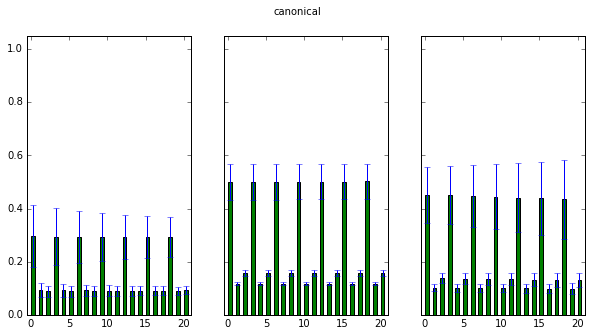

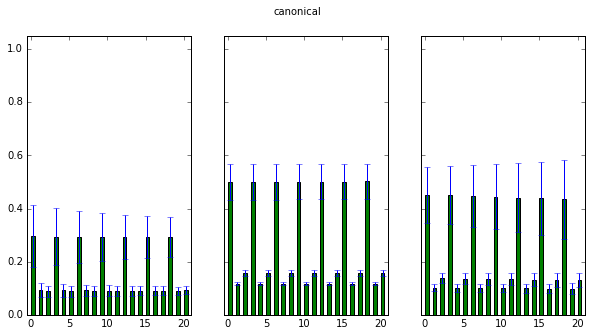

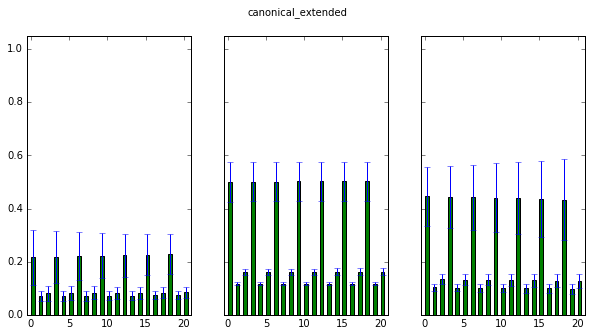

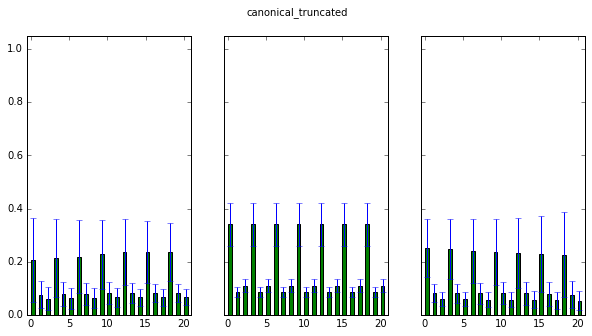

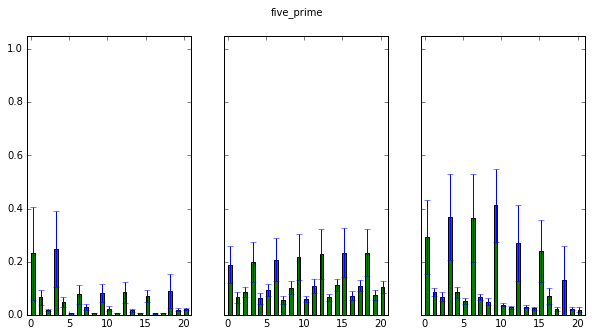

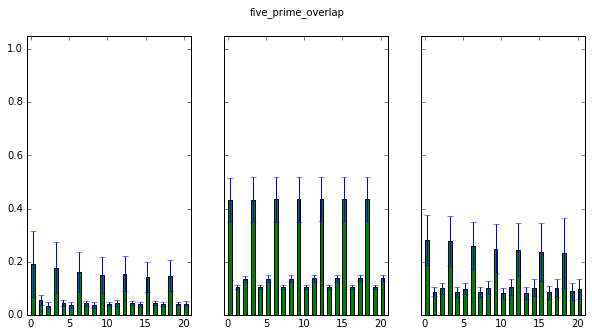

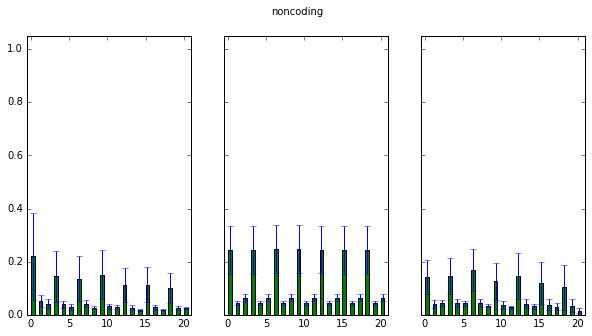

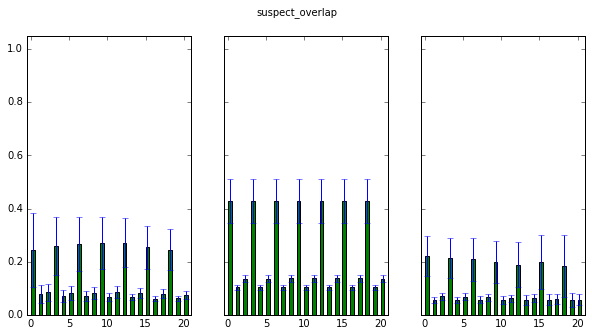

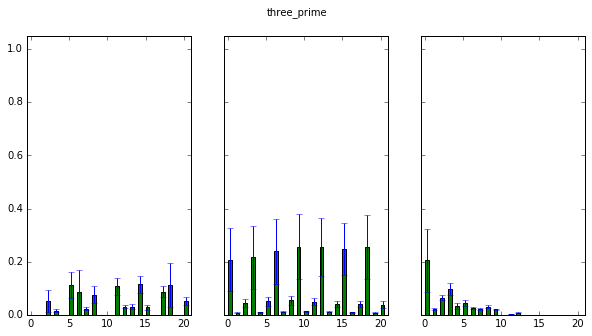

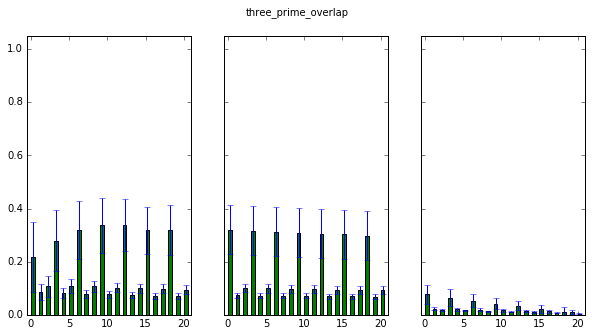

In [34]:
num_cpus = 2
orf_type_groups.apply(run_all, profiles, num_cpus)


100%|██████████| 6057/6057 [00:08<00:00, 684.21it/s]

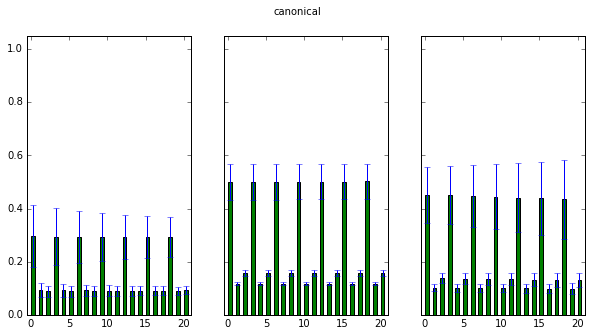

In [31]:
run_all(g, profiles)

In [16]:
orf_type_groups.apply()

orf_type
canonical               6057
canonical_extended       598
canonical_truncated      595
five_prime                19
five_prime_overlap       184
noncoding                118
suspect_overlap          420
three_prime               11
three_prime_overlap     1287
within                 15604
dtype: int64


100%|██████████| 6057/6057 [00:08<00:00, 689.12it/s]

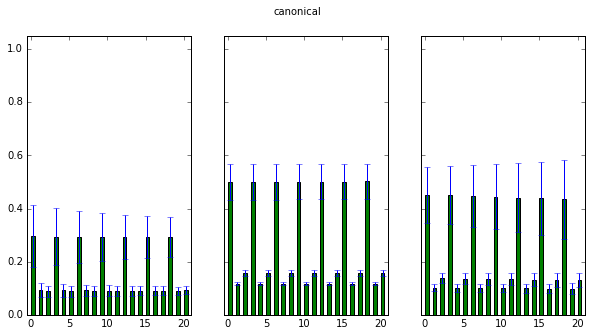

In [19]:
run_all('canonical', orf_type_groups, profiles)


100%|██████████| 184/184 [00:00<00:00, 731.65it/s]

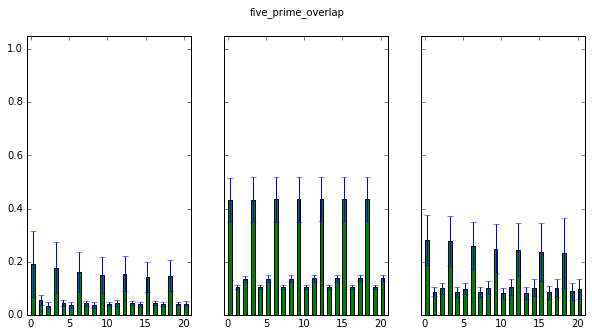

In [22]:
run_all('five_prime_overlap', orf_type_groups, profiles)


100%|██████████| 19/19 [00:00<00:00, 59.50it/s]

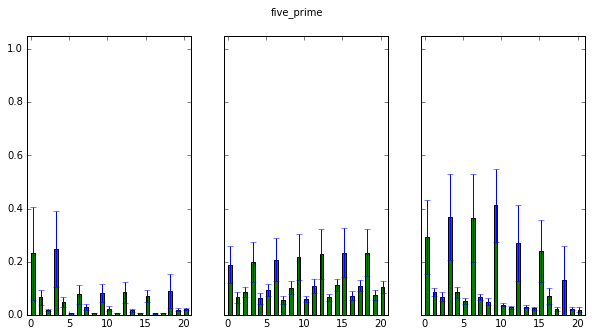

In [23]:
run_all('five_prime', orf_type_groups, profiles)


100%|██████████| 1287/1287 [00:00<00:00, 4419.82it/s]

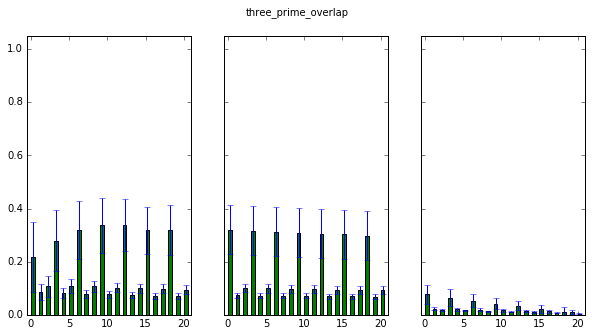

In [24]:
run_all('three_prime_overlap', orf_type_groups, profiles)